In [80]:
import numpy as np
import qnm
import bilby
import matplotlib.pyplot as plt

In [81]:
def shift_model(time, ts, tau, tau_q, fo, f_q, phi, phi_q, A, Aq, t0, **kwargs):
    
    """ 
    quantum shift (not fractional)
    
    """
    
    plus = np.zeros(len(time))
    cross = np.zeros(len(time))
    
    tidxg = time >= t0
    tidxq = time >= ts
    
    GR_part = A*np.exp(-(time[tidxg]-t0)/tau)*np.exp(1j*((time[tidxg]-t0)*2*np.pi*fo) + phi)
    
    
    plus[tidxg] += GR_part.real 
    
    plus[tidxq] += Q_part.real
    
    return {'plus': plus, 'cross': cross}

In [82]:
def frac_shift_1(time, frac_dw, frac_dtau, dphi, A, w, ts, phi, tau, **kwargs):
    
    """ 
    fractional shift: 1 Q mode 
    
    frac_dw, frac_dtau are defined as dw/w (or dtau/tau)
    ts is Q mode start time, phi is phase, w is angular freq., tau is damping time (assumed negative)
        
    outputs plus and cross polarizations as dictionary
    
    """
    
    wave = np.zeros(len(time), np.complex128)
    
    tidq = time >= ts
    
    amplitude = A 
    omegar_term = w * (1+frac_dw)
    time_term_q = (time[tidq] - ts)
    phi_term = phi + dphi
    tau_term = tau * (1+frac_dtau)
    
    wave[tidq] = amplitude * np.exp(1j*(omegar_term*time_term_q)) * np.exp(1j*(phi_term)) * np.exp(time_term_q/(tau*frac_dtau))
    
    
    return {'plus': wave.real, 'cross': wave.imag}

In [83]:
def frac_shift_2(time, frac_dw, frac_dtau, dphi, A, t0, w, ts, phi, tau, **kwargs):
    
    """ fractional shift: superposition of 1 GR mode and 1 Q mode """
    
    wave = np.zeros(len(time), np.complex128)
    
    tidq = time >= ts
    tidg = time >= t0
    
    amplitude = A 
    omegar_term = w * (1+frac_dw)
    time_term_q = (time[tidq] - ts)
    time_term_g = (time[tidg] - t0)
    phi_term = phi + dphi
    tau_term = tau * (1+frac_dtau)
    
    wave[tidq] += amplitude * np.exp(1j*(omegar_term*time_term_q)) * np.exp(1j*(phi_term)) * np.exp(time_term_q/(tau*frac_dtau))
    wave[tidg] += amplitude * np.exp(1j*(w*time_term_g)) * np.exp(1j*(phi)) * np.exp(time_term_g/(tau))
    
    return {'plus': wave.real, 'cross': wave.imag}

In [95]:
def create_bru_values(m_odd, em, M, a, n_ref, A):
    
    """ 
    m_odd is odd integer, g_s is string coupling (GR == 1), em is 2,
    M is total mass, a is dimensionless spin, and amplitude_qnm is 
    the amplitude of the mode of interest 
    
    returns dictionary: amplitude (quantum, g_s version), omega_real, tau, ts, freq
    outputs tau as a negative number
    
    a refractive index of 1 implies no leakage, AND does not work in this limit
        only the subrelativistic (slow) modes can escape (n>>1) based on boundary conditions 
        (i.e. this has to be a black hole copycat)
        
        something to consider is that g_s cannot 0 (which is GR) in this model, otherwise there will be 
        no leakage and coupling to outside the "event horizon," allowing stuff to escape
        
        this implies that g_s would be between ~0.1 and also much less than 1
        it's thought that g_s cannot differ much from GR predictions (so coupling to other
        stringy matter should be small, nonzero)
         
    """
    g_s = np.sqrt(g_2s)
    c = 3e8
    G = 6.67e-11
    Msun = 1.989e30
    n_ref = 3
    
    conversion_w = (c**3)/(G * M * Msun)
    R_con = (2 * G * M * Msun) / (c**2)
    
    r_s = (R_con + np.sqrt((R_con**2) - 4*(a**2)))/2 #units m, kerr+ radius 
    omega_real = (m_odd * np.pi /(2 * r_s * n_ref)) * c   #units 1/m --> 1/s
    omega_im = - (1/r_s) * (1/(n_ref**2)) * c
    
    tau = 1/omega_im
    ts = 1/omega_real 
    
    amplitude = (g_s**4) * A
    
    print("Q freq is {}".format(omega_real/(2*np.pi)))
    print("Q tau is {}".format(tau))
    
    return {'omega_real_Q': omega_real, 'omega_img_Q': omega_im,
            'tau_Q': tau, 'ts_Q': ts, 'amplitude_Q': amplitude, 'freq_Q': (omega_real/(2*np.pi)),
           'rs_Q': r_s}

In [96]:
def create_GR_values(s, l, m, n, a, M):

    """
    grabs GR values to compare to quantum values
    assumes M in units Msun
    converts from 1/m --> 1/s for angular frequency using GR conversion
    
    returns dictionary of GR tau and GR real omega
    outputs tau as a negative number
    
    """
    
    c = 3e8
    G = 6.67e-11
    Msun = 1.989e30
    conversion_w = (c**3)/(G * M * Msun)
    
    grav = qnm.modes_cache(s=s,l=l,m=m,n=n)
    omega_GR, _, _ = grav(a=a)
    
    omega_real_GR = omega_GR.real * conversion_w
    omega_im_GR = omega_GR.imag * conversion_w
    tau_GR = 1/omega_im_GR
    
    print("GR freq is {}".format(omega_real_GR/(2*np.pi)))
    print("GR tau is {}".format(tau_GR))
    
    return {'tau': tau_GR, 'omega_real_GR': omega_real_GR}

In [97]:
s=2
l=2
m=2
n=0
a=0.7
M=50
t0=0

A = 5e-16

GR_values = create_GR_values(2, l , m, n, a, M)
Q_values = create_bru_values(1, 0, M, a, g_2s, A)

#create fractional for each term

w = GR_values['omega_real_GR']
w_q = Q_values['omega_real_Q']
dw = np.abs(w - w_q)
frac_dw = dw/w

phi = 0
dphi = 0

tau = GR_values['tau']
tau_q = Q_values['tau_Q']
dtau = np.abs(tau-tau_q)
frac_dtau = np.abs(dtau/tau)

A_q = Q_values['amplitude_Q']
dA = np.abs(A-A_q)
frac_dA = dA/A

ts = Q_values['ts_Q']

duration = 1.0
sampling_frequency = 4096
outdir = 'outdir'
label = 'shift_220_M50_frac'

GR freq is 345.02823388207537
GR tau is -0.003040841645301787
Q freq is 169.598458693032
Q tau is -0.004422209999900277


In [98]:
#parameters from above
injection_parameters = dict(frac_dw=frac_dw, frac_dtau=frac_dtau, 
                            dphi=dphi, A=A, w=w, t0=0, phi=0, tau=tau,
                            geocent_time=0, ra=0, dec=0, psi=0, ts=ts) 

In [99]:
waveform = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    time_domain_source_model=frac_shift_1,
    start_time=injection_parameters['geocent_time']-ts)

In [100]:
times = waveform.time_array
wave = frac_shift_1(times, **injection_parameters)['plus']

(0, 0.02)

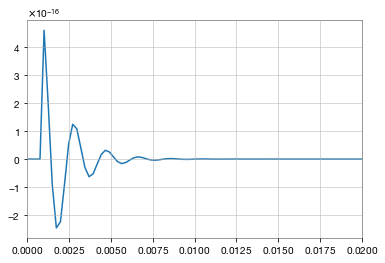

In [101]:
plt.plot(times, wave)
plt.xlim(0,0.02)

In [102]:
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time']-ts)

ifos.inject_signal(waveform_generator=waveform,
                   parameters=injection_parameters)

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
15:09 bilby INFO    : Injected signal in H1:
15:09 bilby INFO    :   optimal SNR = 1963512.69
15:09 bilby INFO    :   matched filter SNR = 1963511.99-1.20j
15:09 bilby INFO    :   frac_dw = 0.5084504917617907
15:09 bilby INFO    :   frac_dtau = 0.4542717167573508
15:09 bilby INFO    :   dphi = 0
15:09 bilby INFO    :   A = 5e-16
15:09 bilby INFO    :   w = 2167.876329689978
15:09 bilby INFO    :   t0 = 0
15:09 bilby INFO    :   phi = 0
15:09 bilby INFO    :   tau = -0.003040841645301787
15:09 bilby INFO    :   geocent_time = 0
15:09 bilby INFO    :   ra = 0
15:09 bilby INFO    :   dec = 0
15:09 bilby INFO    :   psi = 0
15:09 bilby INFO    :   ts = 0.0009384221078327185
15:09 bilby INFO    : Injected signal in L1:
15:09 bilby INFO 

[{'plus': array([5.51229595e-20+0.00000000e+00j,
         5.51223810e-20-4.01345327e-22j,
         5.51206448e-20-8.02722950e-22j, ...,
         6.77129916e-20+1.56419566e-21j,
         6.77264590e-20+7.82149043e-22j,
         6.77309483e-20+0.00000000e+00j]),
  'cross': array([ 1.48370371e-19+0.00000000e+00j,
          1.48359102e-19-1.86584391e-21j,
          1.48325295e-19-3.73143009e-21j, ...,
         -7.65410314e-21-2.20806768e-22j,
         -7.65639509e-21-1.10413623e-22j,
         -7.65715911e-21+0.00000000e+00j])},
 {'plus': array([5.51229595e-20+0.00000000e+00j,
         5.51223810e-20-4.01345327e-22j,
         5.51206448e-20-8.02722950e-22j, ...,
         6.77129916e-20+1.56419566e-21j,
         6.77264590e-20+7.82149043e-22j,
         6.77309483e-20+0.00000000e+00j]),
  'cross': array([ 1.48370371e-19+0.00000000e+00j,
          1.48359102e-19-1.86584391e-21j,
          1.48325295e-19-3.73143009e-21j, ...,
         -7.65410314e-21-2.20806768e-22j,
         -7.65639509e-21-1.

In [103]:
#create priors
prior = injection_parameters.copy()

#prior['tau'] = bilby.core.prior.Uniform(-0.1, -0.0001, r'damping time', unit='$s$')
prior['frac_dtau'] = bilby.core.prior.Uniform(1, 50, r'fraction damping time')

#prior['w'] = bilby.core.prior.Uniform(0, 3000, r'omega', unit='$rad/sec$')
prior['frac_dw'] = bilby.core.prior.Uniform(0.1, 1, r'fraction omega')

prior['ts'] = bilby.core.prior.Uniform(0.005, 0.01, r'start time')

In [104]:
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform)

In [105]:
result = bilby.run_sampler(
    likelihood=likelihood, priors=prior, sampler='dynesty', npoints=500, walks=10, nact=5,
    injection_parameters=injection_parameters, outdir=outdir, label=label, resume=False)

15:09 bilby INFO    : Running for label 'shift_220_M50_frac', output will be saved to 'outdir'
15:09 bilby INFO    : Using LAL version Branch: None;Tag: lal-v6.22.0;Id: 38829b72bfb5f26391b9866d286dd77db7942dd1;;Builder: Duncan Macleod <duncan.macleod@ligo.org>;Repository status: CLEAN: All modifications committed
15:09 bilby INFO    : Search parameters:
15:09 bilby INFO    :   frac_dw = Uniform(minimum=0.1, maximum=1, name='fraction omega', latex_label='fraction omega', unit=None, boundary=None)
15:09 bilby INFO    :   frac_dtau = Uniform(minimum=1, maximum=50, name='fraction damping time', latex_label='fraction damping time', unit=None, boundary=None)
15:09 bilby INFO    :   ts = Uniform(minimum=0.005, maximum=0.01, name='start time', latex_label='start time', unit=None, boundary=None)
15:09 bilby INFO    :   dphi = 0
15:09 bilby INFO    :   A = 5e-16
15:09 bilby INFO    :   w = 2167.876329689978
15:09 bilby INFO    :   t0 = 0
15:09 bilby INFO    :   phi = 0
15:09 bilby INFO    :   ta

0it [00:00, ?it/s]

15:09 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x11cd9a190>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
15:09 bilby INFO    : Checkpoint every n_check_point = 400000
15:09 bilby INFO    : Using dynesty version 1.0.1
15:09 bilby INFO    : Using the bilby-implemented rwalk sample me

1231it [00:07, 71.14it/s, bound:0 nc:4 ncall:5760 eff:21.4% logz-ratio=-inf+/-nan dlogz:inf>0.10]  

15:09 bilby WARNING : Run terminated with signal 2
15:09 bilby INFO    : Writing checkpoint file outdir/shift_220_M50_frac_resume.pickle



Exception while calling prior_transform function:
  params: [0.48817097 0.49929192 0.09025822]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/dynesty/dynesty.py", line 939, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/core/sampler/dynesty.py", line 540, in prior_transform
    return self.priors.rescale(self._search_parameter_keys, theta)
  File "/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/core/prior.py", line 449, in rescale
    return list(flatten([self[key].rescale(sample) for key, sample in zip(keys, theta)]))
  File "/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/core/prior.py", line 449, in <listcomp>
    return list(flatten([self[key].rescale(sample) for key, sample in zip(keys, theta)]))
  File "/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/core/prior.py", line 1137, in rescale
    self.test_valid_for_rescaling(val)
 

SystemExit: 130

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2886: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


1243it [00:20, 71.14it/s, bound:0 nc:4 ncall:5835 eff:21.3% logz-ratio=-inf+/-nan dlogz:inf>0.10]

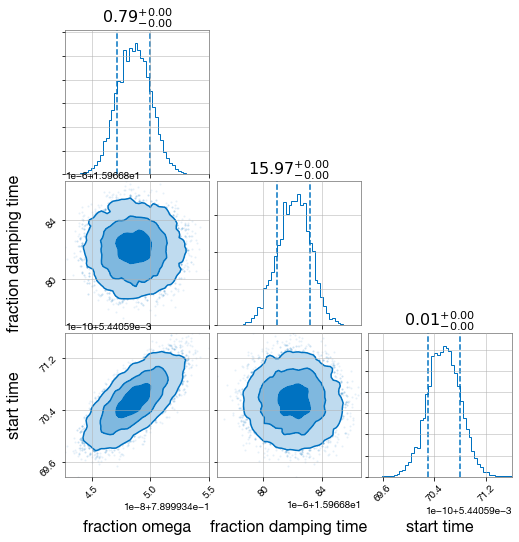

In [155]:
result.plot_corner()